In [1]:
from collections import defaultdict
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, confusion_matrix

In [2]:
# Load data
folder_path = "../results/base/"
data = []

for root, dirs, files in os.walk(folder_path):
    for filename in files:
        if filename.endswith(".json"):
            file_path = os.path.join(root, filename)
            try:
                with open(file_path, "r") as f:
                    entry = json.load(f)
                    data.append(entry)
            except json.JSONDecodeError as e:
                print(f"Skipped invalid JSON: {file_path} ({e})")

print(f"Loaded {len(data)} valid JSON result files from '{folder_path}' and its subfolders.")

Loaded 4218 valid JSON result files from '../results/base/' and its subfolders.


In [42]:
from sklearn.metrics import confusion_matrix
import pandas as pd

# make sure y_true and y_pred are your flat lists/arrays of lowercase labels
labels = sorted(["gpt", "llama", "gemini", "claude", 
                 "qwen", "deepseek", "mistral"])

y_true, y_pred, y_guesser = [], [], []
for entry in data:
    y_true.append(entry['model_general_name_1'])  # agent_0 guess target
    y_pred.append(entry['agent_0_guess'])
    y_guesser.append(entry['model_general_name_0'])
    y_true.append(entry['model_general_name_0'])  # agent_1 guess target
    y_pred.append(entry['agent_1_guess'])
    y_guesser.append(entry['model_general_name_1'])

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_guesser = np.array(y_guesser)
y_true_pred = y_true == y_pred
guesses_df = pd.DataFrame({"y_guesser": y_guesser, "y_guessee": y_true, "y_pred": y_pred, "y_pred_is_true": y_true_pred})

In [43]:
all_positives = guesses_df.groupby(["y_guesser", "y_pred"]).agg(all_positives=("y_pred", "size"))
all_positives.index.set_names(['y_guesser', 'y_guessee'], inplace=True) 
agg = guesses_df.groupby(["y_guesser", "y_guessee"]).agg(true_positives=("y_pred_is_true", "sum"), tp_and_fn=("y_guessee", "size"))
agg["all_positives"] = all_positives["all_positives"]
agg["precision"] = agg["true_positives"] / agg["all_positives"]
agg["recall"] = agg["true_positives"] / agg["tp_and_fn"]

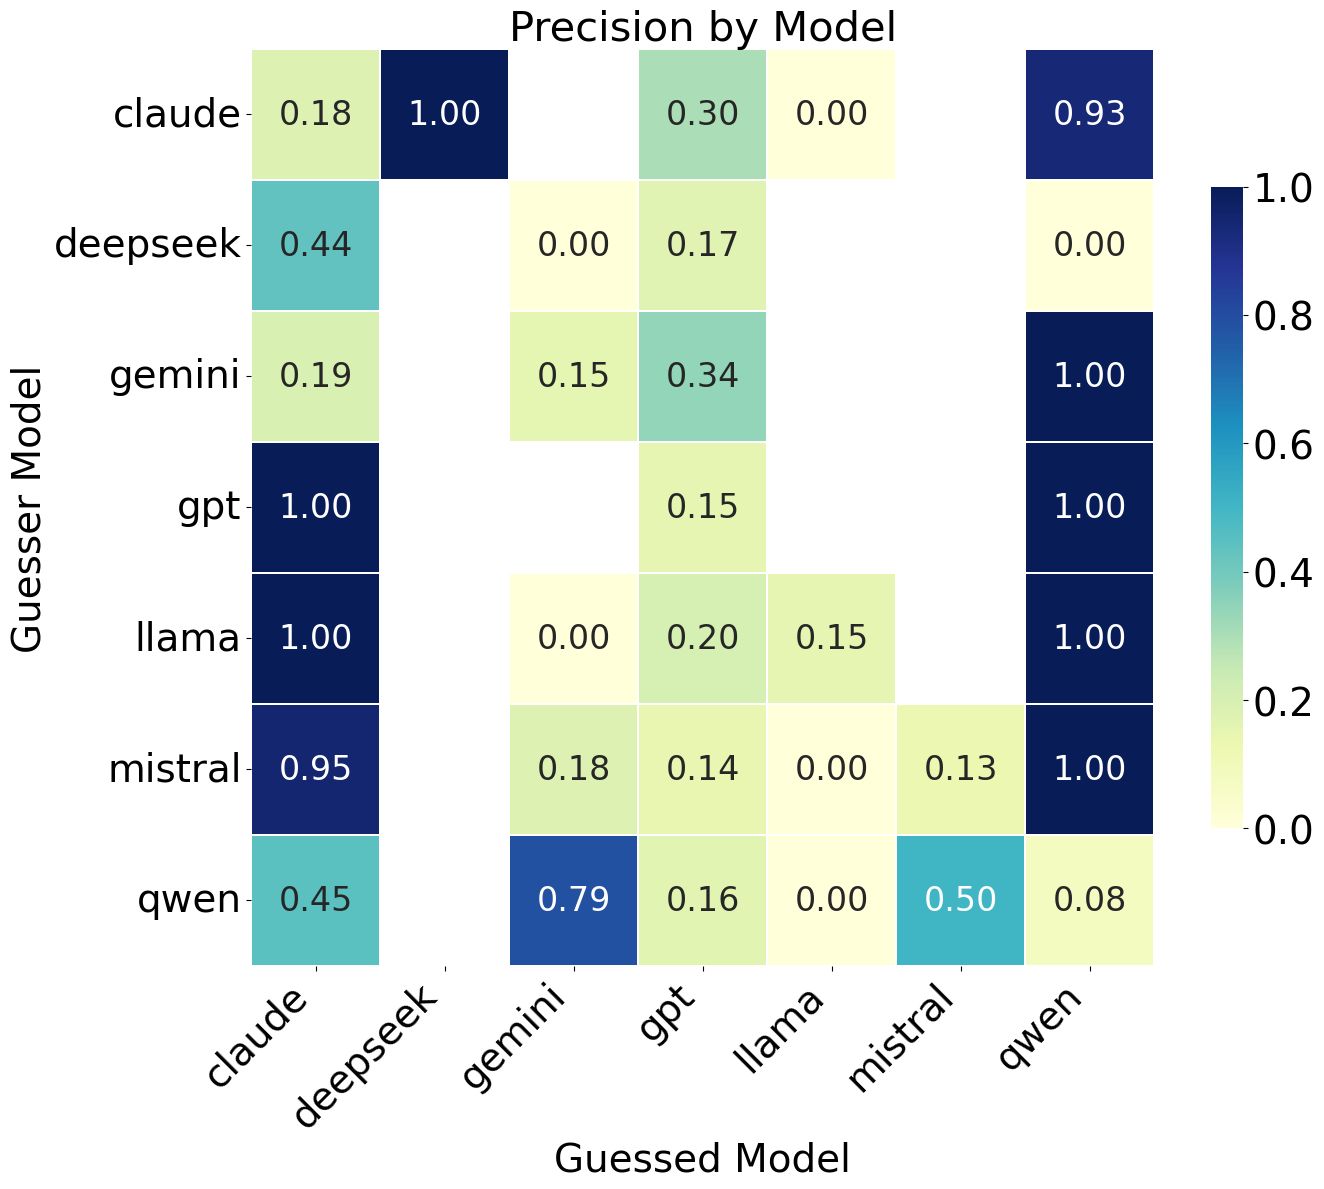

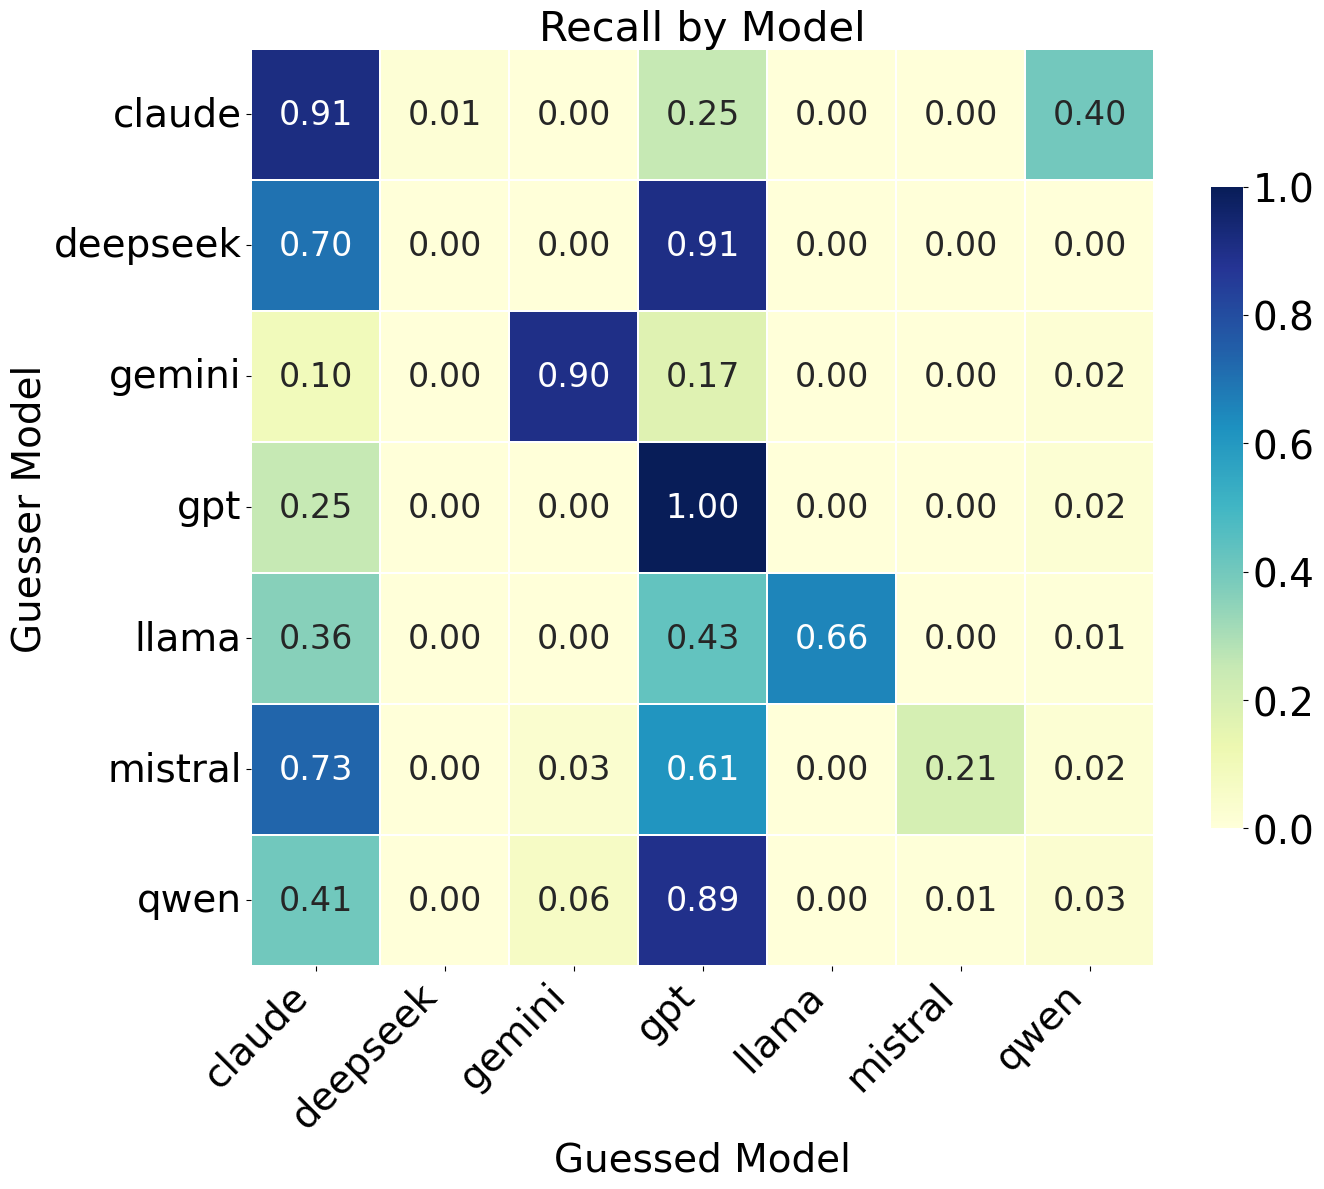

In [44]:
# 4) Plotting helper
def plot_heatmap(df, title, save_file_name):
    matrix = df.unstack(level=1)
    plt.figure(figsize=(14, 12))
    ax = sns.heatmap(
        matrix,
        annot=True, fmt='.2f',
        cmap='YlGnBu',
        linewidths=0.3,
        cbar_kws={"shrink": 0.7},
        annot_kws={"fontsize": 24}
    )
    ax.set_title(title, fontsize=30)
    
    xticks = ax.get_xticklabels()
    yticks = ax.get_yticklabels()
    x_labels = labels #[pretty_names.get(label.get_text(), label.get_text()) for label in xticks]
    y_labels = labels #[pretty_names.get(label.get_text(), label.get_text()) for label in yticks]
    ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=28)
    ax.set_yticklabels(y_labels, rotation=0, fontsize=28)
    
    ax.set_xlabel('Guessed Model', fontsize=28)
    ax.set_ylabel('Guesser Model', fontsize=28)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=28)

    plt.tight_layout()
    plt.savefig("figures_and_files/" + save_file_name, dpi=300, bbox_inches='tight')
    plt.show()

# 5) Display both metrics
plot_heatmap(agg["precision"], 'Precision by Model', 'precision.eps')
plot_heatmap(agg["recall"], 'Recall by Model', 'recall.eps')